In [1]:
import numpy as np
import scipy.stats as st
from scipy.optimize import minimize
import pickle

In [2]:
GP_nominal= pickle.load(open(r'D:\Network Security\KL Control\robotarium_python_simulator\rps\examples\DR_ROBOTARIUM\GP_nominal.dump','rb'))

In [3]:
def model_step(x,velocities,time_step):
    """
    Actual System Model P(.)
    Args:
        x (array): State
        velocities (array): Control velocities
        time_step (float): Time step
    Returns:
        array: Next state
    """
    poses = np.zeros((2,1))
    
    # Update dynamics of agents
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    
    return(poses)

def reference_model_step(x,velocities,time_step):
    """
    reference System Model Q(.)
    Args:
        x (array): State
        velocities (array): Control velocities
        time_step (float): Time step
    Returns:
        array: Next state
    """
    poses = np.zeros((2,1))
    
    # Update dynamics of agents
    poses[0] = 0.80*x[0] + time_step*velocities[0]
    poses[1] = 0.80*x[1] + time_step*velocities[1]
    
    return(poses)

def nominal_model_step(x,velocities,time_step):
    """
    Nominal System Model P^{bar}(.)
    Args:
        x (array): State
        velocities (array): Control velocities
        time_step (float): Time step
    Returns:
        array: Nominal next state
    """
    poses = np.zeros((2,1))
    
    # Update dynamics of agents
    poses[0] = 1.0*x[0] + time_step*velocities[0] + 0.1*x[0]
    poses[1] = 1.0*x[1] + time_step*velocities[1] + 0.1*x[1]
    
    return(poses)

def worst_model_step(x,velocities,time_step):
    """
    Worst System Model
    Args:
        x (array): State
        velocities (array): Control velocities
        time_step (float): Time step
    Returns:
        array: Worst case next state
    """
    poses = np.zeros((2,1))
    
    # Update dynamics of agents
    poses[0] = 1.5*x[0] + time_step*velocities[0]
    poses[1] = 1.5*x[1] + time_step*velocities[1]
    
    return(poses)

def logpdf(x, u, covar):
    """
    Gaussian kernel
    Args:
        x (array): Current state
        u (array): Obstacle points
        covar (array): Covariance
    Returns:
        float: Probability of hitting the obstacle
    """
    
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

import numpy as np


def goal_cost(state,goal_points):
    """
    Calculate cost based on the distance between goal point and current robot state
    Args:
        state (array): Current state
        goal_points (array): Goal points
    Returns:
        float: Cost
    """
        
    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) 
   
    return(cost)

def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

def multivariate_rbf_kernel(X1, X2, gamma):
    #Compute the multivariate Radial Basis Function (RBF) kernel between two sets of input points.
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.zeros((n1, n2))

    diff = X1[:] - X2[:]
    K = np.exp(-gamma * np.dot(diff, diff))

    return K

In [4]:
def reference_input(state,U_space_1,U_space_2,goal_points):
    
    """
    Calculate reference input distribution q_u(.) for reaching the goal point
    Args:
        state (array): Current state
        U_space_1 (array): Action space for 1st input
        U_space_2 (array): Action space for 2nd input
        goal_points (array): Goal points
    Returns:
        array: Reference input distribution
    """
    time_step = 0.033
    
    qpf = np.zeros((control_space_size,control_space_size)) #Initialize q_u
    for i in range(control_space_size): # for all possible inputs in 1st axis
        for j in range(control_space_size): # for all possible inputs in 2nd axis
            next_state_reference = reference_model_step(state,[U_space_1[i],U_space_2[j]],time_step) # predicting next nominal state
            cov_nominal = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state_reference.reshape((2,)),cov_nominal) # creating nominal state distribution
            N_samples = 20
            next_sample = f.rvs(N_samples)
            
            cost = [goal_cost(next_sample[i,:],goal_points) for i in range(N_samples)] # calculating goal cost for N samples from nominal state distribution
            policy = np.exp(-np.sum(cost)/N_samples) 
            
            qpf[i,j] = policy
    S2 = np.sum(qpf) 
    
    qpf = np.array([x/S2 for x in qpf]) #Normalize resulting policy
            
    return(qpf)

def state_cost(state,goal_points,obs_points):
    """
    Calculate state cost considering goal and obstacles
    Args:
        state (array): Current state
        goal_points (array): Goal points
        obs_points (array): Obstacle points
    Returns:
        float: State cost
    """
    
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    
    gauss_sum = 0
    
    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*logpdf(state[:2],obs_points[:2,i],covar)
        
    cost = 50*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 5*(np.exp(-0.5*((state[0]-(-1.5))/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[0]-1.5)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[1]-(-1.0))/0.03)**2)/(0.03*np.sqrt(2*np.pi)))
    
    return(cost)

def state_cost_with_weights(state,goal_points,obs_points,weights):
    """
    Calculate state cost considering goal and obstacles using weights
    Args:
        state (array): Current state
        goal_points (array): Goal points
        obs_points (array): Obstacle points
        weights (array): Weights for cost computation
    Returns:
        float: State cost
    """
    
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    
    gauss_sum = 0
    
    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[0,i+1]*logpdf(state[:2],obs_points[:2,i],covar)
        
    cost = -weights[0,0]*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 1*(np.exp(-0.5*((state[0]-(-1.5))/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[0]-1.5)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[1]-(-1.0))/0.03)**2)/(0.03*np.sqrt(2*np.pi)))
    
    return(cost)

In [5]:
def calculate_kl_divergence(mu1, cov1, mu2, cov2):
    """
    Calculate the Kullback-Leibler (KL) divergence between two multivariate Gaussian distributions.

    Args:
        mu1: numpy array of shape (d,), the mean vector of the first Gaussian distribution
        cov1: numpy array of shape (d, d), the covariance matrix of the first Gaussian distribution
        mu2: numpy array of shape (d,), the mean vector of the second Gaussian distribution
        cov2: numpy array of shape (d, d), the covariance matrix of the second Gaussian distribution

    Returns:
        kl_divergence: float, the KL divergence between the two Gaussian distributions
    """
    d = len(mu1)

    # Invert the covariance matrix of the second Gaussian distribution
    cov2_inv = np.linalg.inv(cov2)

    # Calculate the trace term
    trace_term = np.trace(np.matmul(cov2_inv, cov1))

    # Calculate the squared difference in means
    mean_diff = mu2 - mu1
    mean_diff_term = np.dot(np.dot(mean_diff, cov2_inv), mean_diff)

    # Calculate the log-determinant term
    log_det_term = np.log(np.linalg.det(cov2) / np.linalg.det(cov1))

    # Calculate the KL divergence
    kl_divergence = 0.5 * (trace_term + mean_diff_term - d + log_det_term)

    return kl_divergence


def C_tilde(Costs,eta,nominal_prob,reference_prob):
    """
    Calculate C_tilde for cost transformation
    Args:
        Costs (array): Costs array
        eta (float): radius of the KL ball
    Returns:
        float: Transformed cost
    """
    
    def objective(alpha):
        alpha = alpha[0]
        if alpha < 0.0:
            return np.inf  # Return a large number if alpha is non-positive
        term1 = alpha * eta
        term2 = alpha * np.log(np.sum(nominal_prob*((nominal_prob/reference_prob)*np.exp(np.array(Costs)))**(1/alpha)))
        return term1 + term2
    
    # Initial guess for alpha
    initial_guess = [1.0]

    # Constraint definition for scipy.optimize.minimize
    constraints = [
        {'type': 'ineq', 'fun': lambda alpha: alpha[0]-0.0}  # alpha > 0
    ]
    
    # Solve the problem
    result = minimize(objective, initial_guess,constraints=constraints)
    
    c_tilde = np.min([np.max(np.log((nominal_prob/reference_prob)*np.exp(np.array(Costs)))),result.fun])
    
    return c_tilde

In [6]:
control_space_size = 50

U_space_1 = np.array(np.linspace((-0.5),(0.5),control_space_size))
U_space_2 = np.array(np.linspace((-0.5),(0.5),control_space_size))
time_step = 0.033

In [10]:
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
    
    """
    Perform an control step given an expert input
    Args:
        state (array): Current state
        pref (array): Reference input
        U_space_1 (array): Action space for 1st input
        U_space_2 (array): Action space for 2nd input
        goal_points (array): Goal points
        obs_points (array): Obstacle points
    Returns:
        array: Action
    """
       
    time_step = 0.33
   
    exponent = np.zeros((control_space_size,control_space_size))
    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
    for i in range(control_space_size):
        for j in range(control_space_size):
            test_input = np.hstack((state.reshape(-1,), np.array([U_space_1[i],U_space_2[j]]))).reshape(1, -1)
            # next_state_nominal = nominal_model_step(state,[U_space_1[i],U_space_2[j]],time_step)
            next_state_nominal, sigma_nom = GP_nominal.predict(test_input,return_cov=True)
            cov_nom = np.diag(sigma_nom.reshape((2,)))
            # cov_g = np.diag(sigma_g.reshape((2,))**2)
            # cov_nom = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            p_bar = st.multivariate_normal(next_state_nominal.reshape((2,)),cov_nom)
            N_samples = 20
            next_sample = p_bar.rvs(N_samples)
            nominal_pdf = p_bar.pdf(next_sample)
            nominal_prob = nominal_pdf/np.sum(nominal_pdf) 
            
            
           
            next_state_reference = goal_points[:-1]
            cov_reference = np.array([[0.0001, 0.00002], [0.00002, 0.0001]])
            q = st.multivariate_normal(next_state_reference.reshape((2,)),cov_reference)
            reference_pdf = q.pdf(next_sample) + 1e-100
            reference_prob = reference_pdf/np.sum(reference_pdf) 

            # Multiply a scalar to the eta 
            # eta = np.clip(calculate_kl_divergence(goal_points[:-1].reshape((2,)),cov_reference,next_state_nominal.T.reshape((2,)),cov_nom),0.0,100.0) #low eta*
            eta = 1.5*calculate_kl_divergence(goal_points[:-1].reshape((2,)),cov_reference,next_state_nominal.T.reshape((2,)),cov_nom) #high eta
            
            DKL = calculate_kl_divergence(next_state_nominal.T.reshape((2,)),cov_nom,goal_points[:-1].reshape((2,)),cov_reference)
            
            #next_sample = np.reshape(next_sample,(2,N_samples))
            cost = [state_cost(next_sample[i,:],goal_points,obs_points) for i in range(N_samples)]
            
            # DR algorithm 
            c_t = C_tilde(cost,eta,nominal_prob,reference_pdf)
            exponent[i,j]= -eta-c_t
            
            # uncomment following line to implement FPD, and comment line no. 349 and 350
            # log_DKL = np.exp(-DKL-np.sum(cost)/N_samples)
            
            # if log_DKL == 0.0:
            #     log_DKL = 1e-10
                 
            # pf[i,j] = log_DKL
            # pf[i,j] = pref[i,j]*log_DKL #Calculate the DKL for each possible input, get corresponding probability
    tau = 1. #Temperature parameter for low eta tau = 1.0, for high eta tau = 100.
    exp_max = np.max(exponent)
    pf = np.exp((exponent-exp_max)/tau)+1e-10
    S2 = np.sum(pf) #Normalize resulting policy
    #print(pf)
    pf = np.array([x/S2 for x in pf])
            
    flat = pf.flatten()

    # sample_index = np.random.choice(a=flat.size, p=flat)

    # Take this index and adjust it so it matches the original array
    # adjusted_index = np.unravel_index(sample_index, pf.shape)
    #print(adjusted_index)

    # action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))
    
    return(pf,exponent)
    

In [9]:
%%capture
state = np.array(np.mat('0.2;0.9'))
goal_points = np.array(np.mat('-1.4; -0.8; 0'))


obs_points = np.array(np.mat('0 0 0 0 0 -0.8;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))
upf_eta_low, exponent = Control_step(state,U_space_1,U_space_2,goal_points,obs_points)

In [11]:
%%capture
state = np.array(np.mat('0.2;0.9'))
goal_points = np.array(np.mat('-1.4; -0.8; 0'))


obs_points = np.array(np.mat('0 0 0 0 0 -0.8;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))
upf_eta_high, exponent = Control_step(state,U_space_1,U_space_2,goal_points,obs_points)

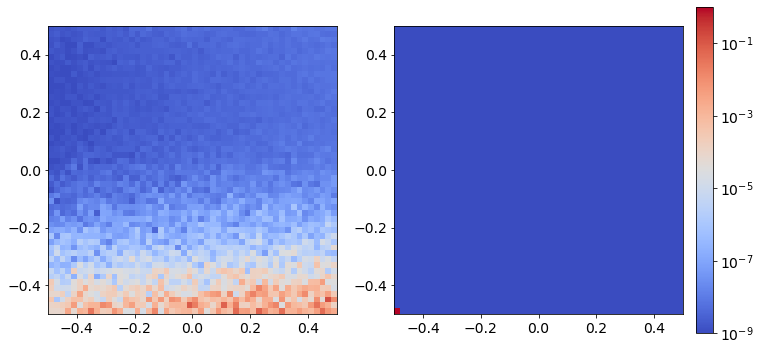

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Custom normalization range
vmin = 1e-9  # minimum value
vmax = 1.0  # maximum value
norm = LogNorm(vmin=vmin, vmax=vmax)

# Create subplots with space for colorbar
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot
im1 = axs[0].imshow(upf_eta_low, extent=(-0.5, 0.5, -0.5, 0.5), origin='lower', cmap='coolwarm', norm=norm)
axs[0].tick_params(axis='x', labelsize=14)  # Change x-tick font size
axs[0].tick_params(axis='y', labelsize=14)  # Change y-tick font size
# axs[0].set_title(r"$\eta(x_{k-1},u_{k})$")

# Second plot
im2 = axs[1].imshow(upf_eta_high, extent=(-0.5, 0.5, -0.5, 0.5), origin='lower', cmap='coolwarm', norm=norm)
axs[1].tick_params(axis='x', labelsize=14)  # Change x-tick font size
axs[1].tick_params(axis='y', labelsize=14) 
# axs[1].set_title(r"$1.5\eta(x_{k-1},u_{k})$")

# Add a shared colorbar
cbar = fig.colorbar(im2, ax=axs, orientation='vertical', fraction=0.032, pad=0.02)
cbar.ax.tick_params(labelsize=14) 
# plt.tight_layout()
plt.show()
# plt.savefig('Policy_diffusion.jpg',dpi=500,bbox_inches ='tight')


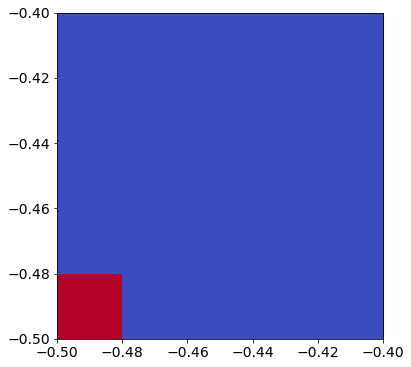

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Custom normalization range
vmin = 1e-9  # minimum value
vmax = 1.0  # maximum value
norm = LogNorm(vmin=vmin, vmax=vmax)

# Create subplots with space for colorbar
fig, axs = plt.subplots(figsize=(12, 6))

# First plot
im1 = axs.imshow(upf_eta_high[:5,:5], extent=(-0.5, -0.4, -0.5, -0.4), origin='lower', cmap='coolwarm')
axs.tick_params(axis='x', labelsize=14)  # Change x-tick font size
axs.tick_params(axis='y', labelsize=14)  # Change y-tick font size
# axs[0].set_title(r"$\eta(x_{k-1},u_{k})$")

# Second plot
# im2 = axs[1].imshow(upf_eta_high, extent=(-0.5, 0.5, -0.5, 0.5), origin='lower', cmap='coolwarm', norm=norm)
# axs[1].tick_params(axis='x', labelsize=14)  # Change x-tick font size
# axs[1].tick_params(axis='y', labelsize=14) 
# # axs[1].set_title(r"$1.5\eta(x_{k-1},u_{k})$")

# Add a shared colorbar
# cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.032, pad=0.02)
# cbar.ax.tick_params(labelsize=14) 
# # plt.tight_layout()
plt.show()
# plt.savefig('Policy_diffusion_high_eta_crop.png',dpi=500,bbox_inches ='tight')